In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [10]:
gears_1: np.ndarray = cv2.imread('trybik.jpg')
gears_2: np.ndarray = cv2.imread('trybiki2.jpg')

gears_inverted_1: np.ndarray = cv2.bitwise_not(gears_1)
gears_inverted_2: np.ndarray = cv2.bitwise_not(gears_2)

In [11]:
from typing import Tuple, List


def contour(image: np.ndarray) -> Tuple[List, int]:
    gray: np.ndarray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    eroded = cv2.erode(binary, np.full((3, 3), 1), iterations=1)
    
    contours, _ = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    maximum_index = max(range(len(contours)), key=lambda x: contours.__getitem__(x).shape[0])
    
    return contours, maximum_index

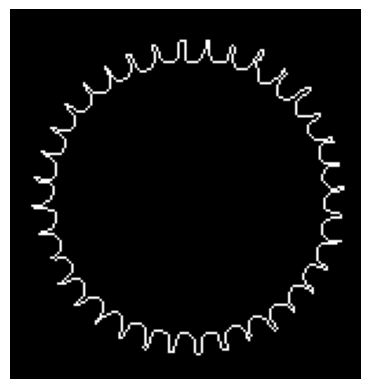

In [12]:
contour_list, max_index = contour(gears_inverted_1)

plt.axis('off')
plt.imshow(
    cv2.drawContours(
        np.zeros(gears_inverted_1.shape[:2], dtype=np.uint8),
        contour_list,
        max_index,
        color=[255]
    ),
    cmap='gray'
)

In [12]:
sobel_x = cv2.Sobel(gears_inverted_1, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gears_inverted_1, cv2.CV_64F, 0, 1, ksize=5)